# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 5: Predicting College Admissions

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

<hr style="height:2.4pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
# RUN THIS CELL
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS


- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models [16 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Interpretable modeling [18 pts]**](#part2)
  - [Solutions](#part2solutions)


- [**Question 3: Harvard and Yale? [30 pts]**](#part3)
  - [Solutions](#part3solutions)


- [**Question 4: Building predictive models for admitted [24 pts]**](#part4)
  - [Solutions](#part4solutions)


- [**Question 5: Evaluating results [12 pts]**](#part5)
  - [Solutions](#part5solutions)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges (one is elite at least :) ): Harvard and Yale.  The data are provided in the file `data/college_admissions.csv` and were scraped from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **school**: a categorical variable for school applied to: "Harvard" or "Yale"
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "school", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models, and you will be replacing the `"school"` variable with a binary `"harvard"` variable early in the questions below.

Please use this dataset to answer the following questions below.

**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty="none"`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models [16 pts]</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?


**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?


**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).


**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?


In [3]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################

college = pd.read_csv("data/college_admissions.csv")
np.random.seed(121)

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["school"],
)

print(college.shape)
print(college_train.shape, college_test.shape)

(1871, 16)
(1496, 16) (375, 16)


<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?
    
</div>

In [4]:
# your code here
admitted = college[college['admitted'] == 1]
prop_admit = len(admitted)/len(college)

admitted_train = college_train[college_train['admitted'] == 1]
prop_admit_train = len(admitted_train)/len(college_train)

admitted_test = college_test[college_test['admitted'] == 1]
prop_admit_test = len(admitted_test)/len(college_test)

print(f"The proportion of people admitted are for whole dataset: {prop_admit:.4f}")
print(f"The proportion of people admitted are for train set: {prop_admit_train:.4f}")
print(f"The proportion of people admitted are for test set: {prop_admit_test:.4f}")



The proportion of people admitted are for whole dataset: 0.2699
The proportion of people admitted are for train set: 0.2627
The proportion of people admitted are for test set: 0.2987


In [5]:
print(f"Here is the accuracy score of the baseline naive model where no one gets in {(1-prop_admit)*100:.3f}%. This\
 is the same as the proportion of people who didn't get in from the whole dataset.")
y_train = college_train['admitted']
y_pred = np.zeros(len(y_train))
accuracy = accuracy_score(y_train, y_pred)*100
print(f"Here is the accuracy of the naive model where no one gets in vs train data: {accuracy:.3f}%")

y_test = college_test['admitted']
y_predtest = np.zeros(len(y_test))
accuracy2 = accuracy_score(y_test, y_predtest)*100
print(f"Here is the accuracy of the naive model where no one gets in vs test data: {accuracy2:.3f}% \n")


print(f"Here is the accuracy score of the baseline naive model where everyone one gets in {(prop_admit)*100:.3f}%. This\
 is the same as the proportion of people who were let in from the whole dataset.")
y_train = college_train['admitted']
y_pred = np.ones(len(y_train))
accuracy = accuracy_score(y_train, y_pred)*100
print(f"Here is the accuracy of the naive model where everyone one gets in vs train data: {accuracy:.3f}%")

y_test = college_test['admitted']
y_predtest = np.ones(len(y_test))
accuracy2 = accuracy_score(y_test, y_predtest)*100
print(f"Here is the accuracy of the naive model where everyone gets in vs test data: {accuracy2:.3f}%")

Here is the accuracy score of the baseline naive model where no one gets in 73.009%. This is the same as the proportion of people who didn't get in from the whole dataset.
Here is the accuracy of the naive model where no one gets in vs train data: 73.730%
Here is the accuracy of the naive model where no one gets in vs test data: 70.133% 

Here is the accuracy score of the baseline naive model where everyone one gets in 26.991%. This is the same as the proportion of people who were let in from the whole dataset.
Here is the accuracy of the naive model where everyone one gets in vs train data: 26.270%
Here is the accuracy of the naive model where everyone gets in vs test data: 29.867%


<div class='exercise-r'>

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.
    
</div>

In [6]:
# Test plot
# plt.figure()
# sns.displot(college_train[college_train['admitted']==1]["test"], label = "Admitted")
# sns.displot(college_train[college_train['admitted']==0]["test"], label = "Not Admitted")


In [7]:
# Test plot 
#bins = 10
# plt.hist(college_train[college_train['admitted']==1]["test"], bins,color = 'blue' ,alpha=0.5, label='Admitted')
# plt.hist(college_train[college_train['admitted']==0]["test"], bins, color = 'red',alpha=0.3, label='Non Admitted')
# plt.legend()

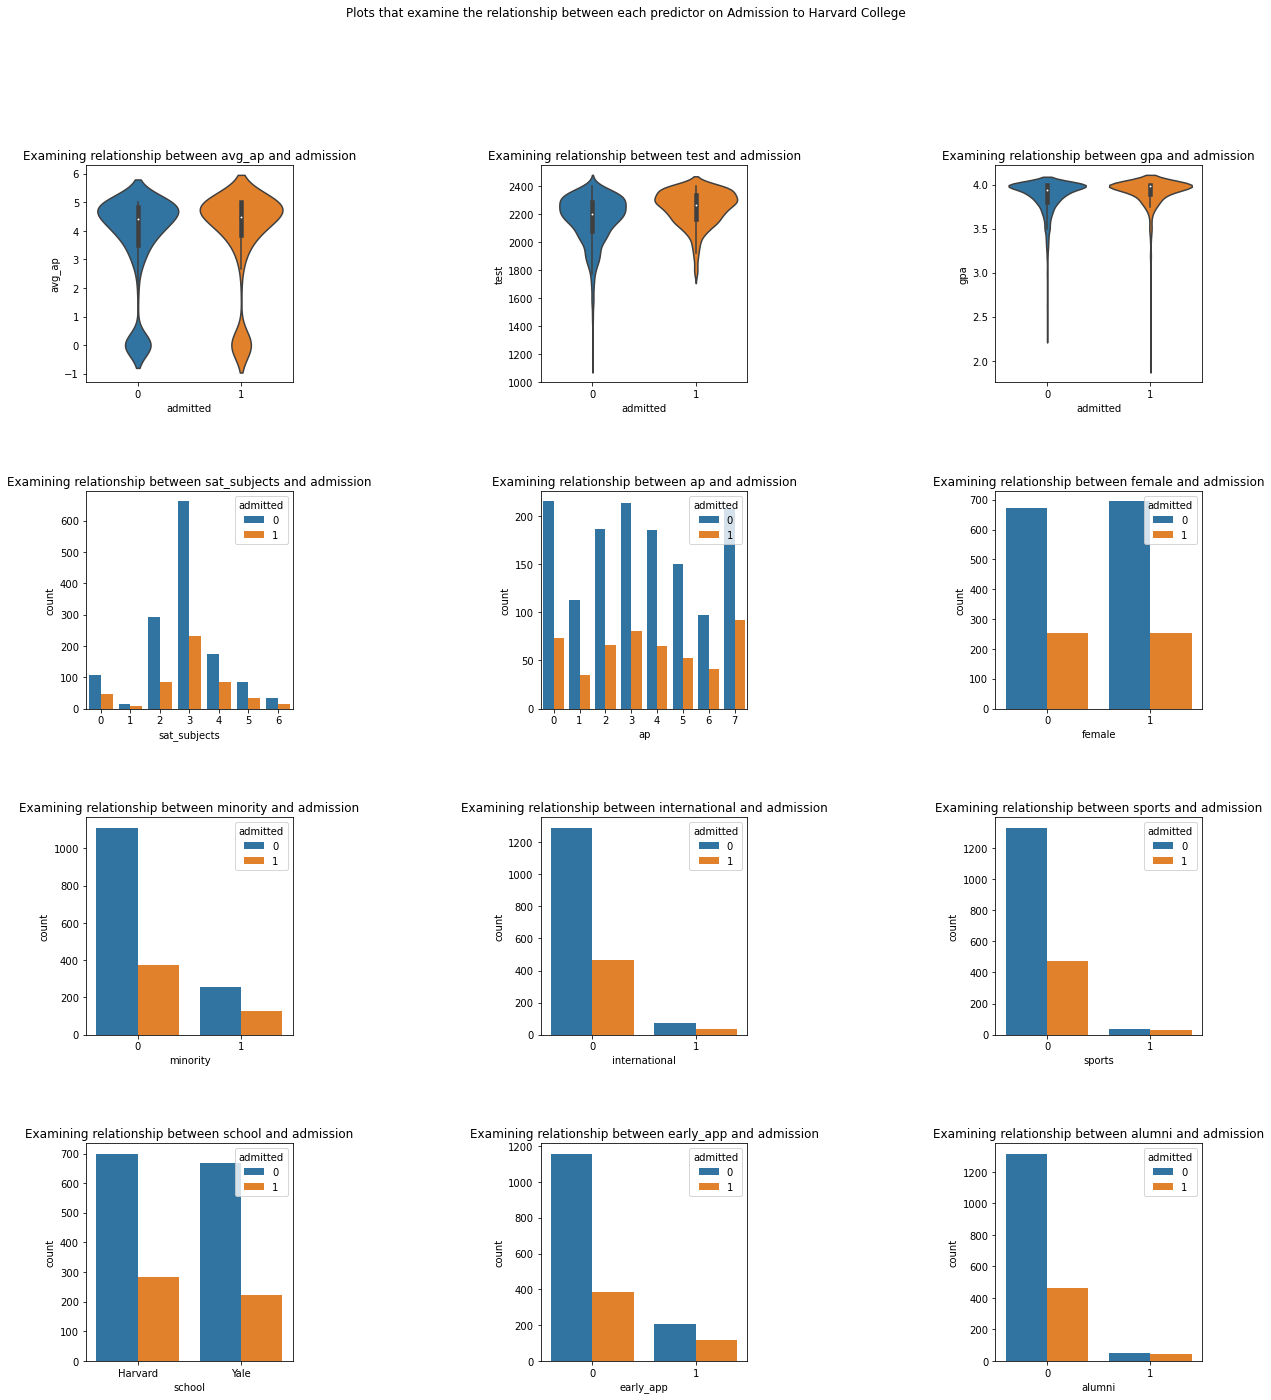

In [8]:
fig, axs = plt.subplots(4,3, figsize = (20, 22))
fig.subplots_adjust(hspace = .5, wspace = 1.2)
axs = axs.flatten()


continuous = ['avg_ap','test', 'gpa']
not_continuous = ['sat_subjects', 'ap', 'female', 'minority', 'international', 'sports', 'school', 'early_app', 'alumni']

plt.suptitle("Plots that examine the relationship between each predictor on Admission to Harvard College")

response = college['admitted']
pred =  college[["test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "school", "early_app", "alumni"]]

for i in range(0,3):
    pred =  continuous[i]
    sns.violinplot(ax=axs[i], data=college, x=response, y=pred)
    axs[i].set_title(f"Examining relationship between {pred} and admission")
    
for i in range(3,12):
    pred=not_continuous[i-3]
    ax = sns.countplot(ax=axs[i], x=pred, hue=response, data=college)
    axs[i].set_title(f"Examining relationship between {pred} and admission")

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

**your answer here**
It is difficult to see a trend between the data from admitted to not admitted. I cannot see where the are more counts or a strong indicator that someone who is admitted falls into a certain category for any of the predictors. The predictor that has the potentially the most clear indicator is the test score. There is a slight distinction between being admitted or not in the violinplot. Those with higher test scores show a slight advantage to getting in than those with lower test scores. This is mostly seen through the lack of tail on the admitted plot as well as it being slightly higher than the one that is not admitted.

<div class='exercise-r'>
    
**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?
    
</div>

In [9]:
college_train['harvard'] = (college_train.school == 'Harvard')*1
college_test['harvard'] = (college_test.school == 'Harvard')*1

<ipython-input-9-b50dd7676d36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_train['harvard'] = (college_train.school == 'Harvard')*1
<ipython-input-9-b50dd7676d36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_test['harvard'] = (college_test.school == 'Harvard')*1


In [10]:
# your code here
harvard_train = college_train[['harvard']]
admit_train = college_train['admitted']

# Test set
harvard_test = college_test[['harvard']]
admit_test = college_test['admitted']

logit1_4 = LogisticRegression(penalty = 'none').fit(harvard_train, admit_train)

# Predict
y_pred_train = logit1_4.predict(harvard_train)
y_pred_test = logit1_4.predict(harvard_test)

print(f"Here is the harvard coefficient: {logit1_4.coef_[0][0]:.3f}")
print(f"Here is the estimated intercept: {logit1_4.intercept_[0]:.3f}")



Here is the harvard coefficient: 0.153
Here is the estimated intercept: -1.114


In [11]:
#Need to solve for probabilities of getting into each school
# Equation for Probabilities
# P(Y=1|X = 1) = 1/exp(-beta0 - beta1)
beta0 = logit1_4.intercept_[0]
beta1 = logit1_4.coef_[0][0]

# X = 1 for Harvard
p_harvard = 1/(1+np.exp(-1*(beta0+beta1)))

# X = 0 for Yale
p_yale = 1/(1+np.exp(-1*(beta0)))

print(f"Here is the probability of getting into Harvard: {p_harvard:.4f}")
print(f'Here is the probability of getting into Yale: {p_yale:.4f}')


Here is the probability of getting into Harvard: 0.2768
Here is the probability of getting into Yale: 0.2472


**INTERPRETATION:**

**your answer here: which college is estimated to be easier to get into? What are the estimated probabilities of getting into each school?**


To assess the estimated probability, let's look at the Probability Mass Function:

$$ P(Y = 1) = p$$
$$ P(Y = 0) = 1- p$$
$$ P(Y = y) = p^{y} (1- p)^{(1-y)}$$

where:

$$ p = P(Y=1, X=x) = \frac{1}{1+ e^{(\beta{0} + \beta{1} X)}}$$

Hence, the estimate probability of getting into harvard is:

$$ p = P(Y=1, X=1) = \frac{1}{1+ e^{-(\beta{0} + \beta{1} 1)}} = 0.2768$$

Hence, the estimate probability of getting into Yale is:

$$ p = P(Y=1, X=0) = \frac{1}{1+ e^{-(\beta{0} )}} = 0.2472$$



---


Harvard: X = 1, Yale: X = 0.

To solve we can use the equation: $ln\dfrac{P(Y=1)}{P(Y=0)} = \beta_0 + \beta_1X$. 

This can then be rewritten for both cases of Harvard and Yale using the above values of X: P(Y=1|X=1) = $\dfrac{1}{1+\exp{-(\beta_0 + \beta_1)}}$ and P(Y=1|X=0) = $\dfrac{1}{1+\exp{-(\beta_0)}}$. 

The probability of getting into Harvard is 0.2768, which is higher than the probability of getting to Yale, 0.2472. 

This means that it is harder to get into Yale. 

---

The coefficients can also indicate which is easier to get into. The intercept is a negative value, which correlates to Yale because in the equation X = 0. The slope or $\beta_1$ is positive, which means we would move up on the line from the intercept when someone is admitted to Harvard or when X = 1. From the coefficients signs we can see that being that Beta0 is negative and that Beta1 is positive, it means that the more x1 we have (in this case Harvard), the more likely a higher (positive) outcome in the admitted predictor. Meaning that it would be easier to get admitted into Harvard compared to Yale.

<div class='exercise-r'>

**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).

</div>

In [12]:
176+536
top = 176/712
bottom = 536/712
beta0 = np.log(top/bottom)

In [13]:
567+217
top = 217/784
bottom = 567/784
total = np.log(top/bottom)
beta1 = total - beta0
print(beta1)

0.1531882158453577


In [14]:
# your code here
pd.crosstab(college_train["admitted"], college_train["harvard"])

harvard,0,1
admitted,,
0,536,567
1,176,217


### Using the Training data set to create the Contigency table this is what we get.
**note** we use the training set because the logit1_4 model is fitted on the training set.

For Yale: 
From the contingency table, we can see that P(Y=1|X=0) = 176/712 and P(Y=0|X=0) = 536/712. We can then take the log and do: $ln\dfrac{P(Y=1|X=0)}{P(Y=0|X=0)} = ln\dfrac{176/712}{536/712} =\beta_0 = -1.1137$

For Harvard: 
From the contingency table, we can see that P(Y=1|X=1) = 217/784 and P(Y=0|X=1) = 567/784. We can then take the log and do: $ln\dfrac{P(Y=1|X=1)}{P(Y=0|X=1)} = ln\dfrac{282/981}{699/981} =\beta_0 + \beta_1 = -0.9605 $. We can then plug in $-1.1137$ for $\beta_0$ to solve for $\beta_1$. We then get that $\beta_1$ = $0.1532$



<div class='exercise-r'>

**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

**your answer here**
The overall acceptance rate for Yale is 5.9% and for Harvard is 4.5% given from the website. We can see that $\beta_0$ is negative value, meaning that it is hard to or someone can expect to not get into Yale. The $\beta_1$ is a positive value and is introduced when you are going to Harvard because X = 1 for Harvard. With a positive $\beta_1$ value, the line will shift or increase with the different values or move us in a positive, upward slope on the line, meaning that it is easier to get into Harvard. The general equation of the line is $ln(\dfrac{P(Y=1)}{P(Y=0)}=\beta_0 + \beta_1X_1 + \beta_2 X_2 +...+ \beta_n X_n$. 

The equation that is used in this question is further reduced to: 
$ln(\dfrac{P(Y=1)}{P(Y=0)}=\beta_0 + \beta_1X_{harvard}$.


Possible reasons for the strong difference between the website probabilities is that our model's probabilities are:

* self-selection: this data was scraped from the website collegedata.com, where students voluntarily input this data. It means that there is bias in the data because students who are admitted are more likely to report their admission rather than students who were not admitted. Given this, it makes sense that our probability of being admitted to Harvard or Yale is way higher than the website https://www.ivycoach.com/2023-ivy-league-admissions-statistics/ , where the entirity of applications is taken into consideration.
* On the website they are considering several schools, in our case we are determining not the overall probability to get into Harvard, but the probability of getting into Harvard based on where these specific students applied to. All these students either applied to Harvard or Yale. Consequently, this dataset is already pre-selected - because students autoselect themselves when they apply for ivy leagues schools. Meaning, students applying for this kind of schools are more likely to have high grades and more likely to be admitted in this kind of schools in general. Consequently, our dataset is considering a very small sample that is not representative - consequently it's clear why our probabilities are very much off compared to the website given.

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling [18 pts]</div>

[Return to contents](#contents)

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data). 

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?

**2.3**  Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data). 

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.


<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data).
    
</div>

In [15]:
# your code here
test_train = college_train[['test']]
admit_train = college_train['admitted']

test_test = college_test[['test']]
admit_test = college_test['admitted']

# Initialize 
logit2_1 = LogisticRegression(penalty = 'none').fit(test_train, admit_train)

# Predict
y_pred_train = logit2_1.predict(test_train)
y_pred_test = logit2_1.predict(test_test)

coef = logit2_1.coef_
intercept = logit2_1.intercept_

# Accuracies 
train_score = accuracy_score(admit_train, y_pred_train)*100
test_score = accuracy_score(admit_test, y_pred_test)*100

print(f"Here is the test coefficient {coef[0][0]:.3f} and the intercept {intercept[0]:.3f}")
print(f"Here is the accuracy from the train data: {train_score:.3f}%")
print(f"Here is the accuracy from the test data: {test_score:.3f}%")


Here is the test coefficient 0.004 and the intercept -9.414
Here is the accuracy from the train data: 73.730%
Here is the accuracy from the test data: 70.133%


<div class='exercise-r'>

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?
    
</div>

**From Slide 6 from Lecture15 about Logistic regression:**

The test score needed to have a 50-50 chance of being admitted (i.e. 0.5 proability) is defined at the decision boundary. 

The decision boundary is: 

$$ 0.5 = \frac{1}{1 + e^{-\beta_{intercept} -\beta_{test} X_{test} }} $$

Meaning that:

$$ 1 = e^{-\beta_{intercept} -\beta_{test} X_{test}} $$ 

$$ -\beta_{intercept} -\beta_{test} X_{test} = 0 $$

All times -1:

$$ +\beta_{intercept} +\beta_{test} X_{test} = 0 $$



Hence, the test score needed to have a 50% probability of getting admitted is:

$$ X_{test 50\%} =  \frac{\beta_{intercept}}{\beta_{test}}$$

In [16]:
# your code here
logit2_1.predict([[2250]])
#logit2_1.classes_
# gives back 0, 1
# 1 = admitted
p1 = logit2_1.predict_proba([[2250]])[0,1]*100
print(f"Probability of getting admitted with a 2250: {p1:.4f}%")
                 
logit2_1.predict([[2400]])
#gives back 0,1
p2 = logit2_1.predict_proba([[2400]])[0,1]*100
print(f"Probability of getting admitted with 2400: {p2:.4f}%")

## Need to find 50-50 chance
# this is to high
test_score = -intercept[0]/coef[0][0]
print(f"Test score needed in order to get 50/50 chance of being admitted: {test_score:.0f}")



Probability of getting admitted with a 2250: 29.2949%
Probability of getting admitted with 2400: 42.2561%
Test score needed in order to get 50/50 chance of being admitted: 2482


**your answer here**
In order to find the 50/50 chance of being admitted, we have a logistic regression that is linear. The equation for Logistic Regression is:\
$ln(\dfrac{P(Y=1)}{P(Y=0)} = \beta_0 + \beta_1 X_1$ \
This line ($\beta_0 + \beta_1X_1$) can be extrapolated to find the test score that crosses the x-axis (or equation equals zero). The reason we want to cross the x-axis or find when the value of the line is 0 is because to get the probability to 50, then the odds are 1 and the log odds of that is zero. Thus, we can find the classification boundary can be seen as:
$\beta_0 + \beta_1 X_1$ = 0. \
Now we can solve for $X_1$ or test score in this example: \
$\beta_1 X_1 = -\beta_0$ \
$X_1 = \dfrac{-\beta_0}{\beta_1}$ = 2482

The test score needed in order to have of 50/50 chance of being addmited is 2482.





<div class='exercise-r'>

**2.3** Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data).
    
</div>

In [17]:
# your code here
X_train = college_train[['test', 'avg_ap']]
admit_train = college_train['admitted']

X_test = college_test[['test', 'avg_ap']]
admit_test = college_test['admitted']

logit2_3 = LogisticRegression(penalty = "none").fit(X_train, admit_train)
y_pred_train = logit2_3.predict(X_train)
y_pred_test = logit2_3.predict(X_test)

coef = logit2_3.coef_
intercept = logit2_3.intercept_

accuracy_train = accuracy_score(admit_train, y_pred_train)*100
accuracy_test = accuracy_score(admit_test, y_pred_test)*100

print(f"Here is the accuracy score for training data {accuracy_train:.3f}%\n" \
     f"Here is the accuracy score for the test data {accuracy_test:.3f}%\n")

predictors = ['test', 'avg_ap']
for i in range(len(predictors)):
    print(f"Here is the {predictors[i]} coefficient: {coef[0][i]:.3f}\n")
print(f"Here is the intercept: {intercept[0]:.3f}\n")

Here is the accuracy score for training data 73.730%
Here is the accuracy score for the test data 70.133%

Here is the test coefficient: -0.001

Here is the avg_ap coefficient: 0.053

Here is the intercept: -0.019



<div class='exercise-r'>

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

</div>

Text(0.5, 1.0, 'ScatterPlot: Comparision of Test Scores and Average AP Scores')

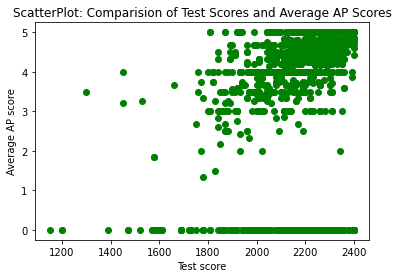

In [18]:
# your code here
plt.figure()
plt.plot(college_train[["test"]], college_train[["avg_ap"]], "go" ,label = "Test")
plt.xlabel("Test score")
plt.ylabel("Average AP score")
plt.title("ScatterPlot: Comparision of Test Scores and Average AP Scores")

**INTERPRETATION:**

**your answer here** \
 Relationship between test and avg_ap: The higher a student's grades, the most likely it is that this student is also getting high scores for AP tests. Although the pearson correlation is not that near to 1, it is still not 0, meaning that there is some sort of linear relationship and linear correlation between the average grade of tests and the average ap score.

If the correlation between 2 variables is 0, it means there is just 1 solution, hence 1 possible solution for their coefficients. In case the correlation is 1, there are infinite solutions and the value of the beta won't be stable.

In this example, given that are correlated test and avg_ap, it means they roughly explain almost the same thing. Hence, the beta coefficient from logit2_1 and logit2_3 cannot be the same one. Being that test and avg_ap will explain almost the same, their beta coefficients will then change because part of test will be explained by avg_ap, hence the beta of test will change to let some space for the beta of avg_ap. Had the correlation been 0 between test and avg_ap, then the beta of test would have been the same. Here this is not the case.

<div class='exercise-r'>

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

**your answer here** \
logit2_1: \
Here is the accuracy from the train data: 73.730% \
Here is the accuracy from the test data: 70.133% 

logit2_3: \
Here is the accuracy score for training data 73.730% \
Here is the accuracy score for the test data 70.133% 


We can see that the accuracies the same. Logit2_1 looks at just the test predictor whereas logit2_3 looks at the test and average ap scores. The accuracy score doesn't change meaning that the introduction of another variable does not increase the accuracy of our predictions and true value of if the student is admitted or not because the two are correlated. This means that having a high test score would probably also have a high test score and the model sees that. Had the correlation between test and avg_ap been 0, it means that in that case avg_ap would have explained new information and that new information would have been added, which would have led to a higher accuracy. This is not the case for this situation. Consequently, as test and avg_ap explain similar information, the accuracy did not increase and remained the same between logi2_1 and logit2_3.

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale? [30 pts]</div>

[Return to contents](#contents)

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$

**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [19]:
y_train = college_train['admitted']
x_train = college_train[['harvard', 'test', 'ap', 'avg_ap', 'gpa', 'female', 'minority']]

y_test = college_test['admitted']
x_test = college_test[['harvard', 'test', 'ap', 'avg_ap', 'gpa', 'female', 'minority']]

logit3_1 = LogisticRegression(penalty='none', max_iter=500)
logit3_1.fit(x_train, y_train)
y_pred = logit3_1.predict(x_test)

intercept = logit3_1.intercept_[0]
coef = logit3_1.coef_[0]

# train_accuracy = logit3_1.score(x_train, y_train)*100
# test_accuracy = logit3_1.score(x_test , y_test)*100
# print(f"Train Accuracy: {train_accuracy:.3f}%")
# print(f"Validation Accuracy: {test_accuracy:.3f}%")



In [20]:
predictors = ['harvard', 'test', 'ap', 'avg_ap', 'gpa', 'female', 'minority']
for i in range(len(predictors)):
    print(f"The estimated {predictors[i]} intercept coefficient is: {coef[i]:.3f} \n")


print(f"The estimated intercept coefficient is: {intercept:.3f}" )

The estimated harvard intercept coefficient is: 0.141 

The estimated test intercept coefficient is: 0.003 

The estimated ap intercept coefficient is: -0.020 

The estimated avg_ap intercept coefficient is: 0.031 

The estimated gpa intercept coefficient is: -1.730 

The estimated female intercept coefficient is: -0.027 

The estimated minority intercept coefficient is: 0.450 

The estimated intercept coefficient is: -1.161


In [21]:
# your code here
x_train = college_train[["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]]
admit_train = college_train["admitted"]

x_test = college_test[["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]]
admit_test = college_test["admitted"]

logit3_1 = LogisticRegression(penalty = "none", max_iter = 500).fit(x_train, admit_train)

coef = logit3_1.coef_
intercept = logit3_1.intercept_[0]

predictors = ["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]
for i in range(len(predictors)):
    print(f"Here is the {predictors[i]} coefficient: {coef[0][i]:.3f} \n")
print(f"Here is the intercept {intercept:.3f}")

Here is the harvard coefficient: 0.141 

Here is the test coefficient: 0.003 

Here is the ap coefficient: -0.020 

Here is the avg_ap coefficient: 0.031 

Here is the gpa coefficient: -1.730 

Here is the female coefficient: -0.027 

Here is the minority coefficient: 0.450 

Here is the intercept -1.161


**INTERPRETATION:**


**Interpretation of the binary predictors' coefficients:**

 * Harvard: Given that the coefficient for Harvard=1 is positive, if an applicant applied for Harvard, it is more likely they got admitted into the chosen school, i.e. admitted to Harvard. In this case it means that many people that got into Harvard self-reported more their admission on the website rather than the people that were not admitted
 * Female: For the coefficient Female=1, i.e. if the applicant was a female, given that the coefficient is negative, it means that if the applicant was a female, she would be less likely to be admitted to the school she applied to
 * Minority: For the coefficient minority=1, i.e. if the applicant was part of a minority, given that the coefficient is positive, it means that if the applicant was part of a minority, they would be more likely to be admitted to the school she applied to

* Additionally, given that the magnitude of the minority coefficient is higher than the magnitude of the coefficient for harvard and female, it seems that being part of a minority (or not part of) has more predicting power compared to the factor 'female' or factor 'applied to harvard' in  predicting the outcome of admissions.

**Interpretation of the other predictors' coefficients:**

* Higher test scores results in higher chances of being admitted
* Taking more AP classes results in lower chances of being admitted to the chosen school
* Having on average higher grades in AP clases results in higher chances of being admitted to the chosen school
* Having a higher GPA results in lower chances of getting admitted to the chosen school. This doesn't make much sense and it might be related to self-selection in our dataset. Mostly students self-reporting information in this kind of websites are typically competitive students that care about grades and school, hence probably most students in the dataset have a high GPA anyways. Hence this cannot be considered as the true trend for the general population, where one would expect that the higher the GPA the more likely it is to be admitted to the chosen school.



<div class='exercise-r'>

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

</div>

In [22]:
# your code here

#creating interaction terms
harvard_test_train = college_train[["harvard"]].values*college_train[["test"]].values
harvard_ap_train = college_train[["harvard"]].values*college_train[["ap"]].values

# creating new columns
x_train = college_train[["harvard", "test", "ap"]]
x_train.insert(3,"harvard_test", harvard_test_train)
x_train.insert(4,"harvard_ap", harvard_ap_train)
admit_train = college_train["admitted"]

logit3_2 = LogisticRegression(penalty = "none", max_iter = 500).fit(x_train, admit_train)


x_train.head()

,harvard,test,ap,harvard_test,harvard_ap
584,1,2080,5,2080,5
1817,0,2190,6,0,0
1308,0,2140,2,0,0
1336,0,2120,6,0,0
3,1,2400,5,2400,5


In [23]:
predictors = ["harvard", "test", "ap", "harvard_test", "harvard_ap"]

for i in range(len(predictors)):
    print(f"Here is the {predictors[i]} coefficient: {logit3_2.coef_[0][i]:.3f} \n")
    
print(f"Here is the intercept {logit3_2.intercept_[0]:.3f}")

Here is the harvard coefficient: -4.441 

Here is the test coefficient: 0.003 

Here is the ap coefficient: 0.024 

Here is the harvard_test coefficient: 0.002 

Here is the harvard_ap coefficient: -0.110 

Here is the intercept -7.134


<div class='exercise-r'>

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

</div>

**your answer here** 
## General Equation:

$$ln(\dfrac{P(Y=1|X=1)}{1-P(Y=1|X=1)}) = \beta_0 + \beta_1X_{harvard} + \beta_2X_{test} + \beta_3X_{ap} + \beta_4 X_{harvard-test} + \beta_5 X_{harvard -ap} $$ 

### Harvard X = 1:
$$ln(\dfrac{P(Y=1|X=1)}{1-P(Y=1|X=1)}) = \beta_0 + \beta_1X_{harvard} + (\beta_2 + \beta_4)X_{test} + (\beta_3+ \beta_5)X_{ap} $$

$$ln(\dfrac{P(Y=1|X=1)}{1-P(Y=1|X=1)}) = -7.134 +-4.441*1 + (0.00269 + 0.00224)X_{test} + (0.024 - 0.11) X_{ap} $$ 



### Yale X = 0 :

$$ln(\dfrac{P(Y=1|X=0)}{1-P(Y=1|X=0)}) = \beta_0 + \beta_1X_{harvard} + \beta_2X_{test} + \beta_3X_{ap} + \beta_4 X_{harvard-test} + \beta_5 X_{harvard -ap}$$ 

$$ln(\dfrac{P(Y=1|X=0)}{1-P(Y=1|X=0)}) =  -7.134+ 0 + 0.00269X_{test} + 0.024 X_{ap} + 0 + 0 $$ 



<div class='exercise-r'>

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

</div>

## Solving for Classifiation Boundary
$ln(\dfrac{P(Y=1|X=1)}{1-P(Y=1|X=1)}) = \beta_0 + \beta_1X_{harvard} + \beta_2X_{test} + \beta_3X_{ap} + \beta_4 X_{harvard-test} + \beta_5 X_{harvard -ap} $ 

Decision Boundary for Bayes' classier at 0.5: 

$0 = \beta_0 + \beta_1X_{harvard} + \beta_2X_{test} + \beta_3X_{ap} + \beta_4 X_{harvard-test} + \beta_5 X_{harvard -ap} $ 

$0 = -7.134 +-4.441X_{harvard} + 0.00269X_{test} + 0.024 X_{ap} + 0.00224X_{harvard-test}- 0.11 X_{harvard-ap} $


## Solving for range of values of test as a function of AP

### Harvard
$0  = \beta_0 + \beta_1X_{harvard} + (\beta_2 + \beta_4)X_{test} + (\beta_3+ \beta_5)X_{ap} $ 

$0 = -7.134 +-4.441*1 + (0.00269 + 0.00224)X_{test} + (0.024 - 0.11) X_{ap} $

Need to solve for $X_{test}$

$X_{test} = \dfrac{- (\beta_0 + \beta_1) + (\beta_3 + \beta_5)X_{ap}}{\beta_2 + \beta_4} $

$X_{test} = \dfrac{-(-7.134-4.441) + (0.024 -0.11)X_{ap}}{0.00269 + 0.00224} $

$X_{test} = \dfrac{11.575 -0.086X_{ap}}{0.00493} $
 
To get the range, we can test the range of $X_{ap}$ values given.

For $X_{ap}$ = 0: 

$X_{test} = \dfrac{11.575 -0.086*0}{0.00493} $ 

$X_{test} = \dfrac{11.575}{0.00493} = 2347.87 $ 

For $X_{ap}$ = 7:

$X_{test} = \dfrac{11.575 -0.086*7}{0.00493} $ 

$X_{test} = \dfrac{10.973}{0.00493} = 2225.76 $ 

The range of test scores is then (for AP = 0)  2347.87 to (AP = 7) 2225.76 .

### Yale
$0  = \beta_0 + \beta_1X_{harvard} + \beta_2 X_{test} + \beta_3X_{ap} + \beta_4X_{harvard-test} + \beta_5 X_{harvard-ap} $ 

$0 = -7.134 +-4.441*0 + 0.00269X_{test} + 0.024 X_{ap} + 0.00224 *0 + - 0.11*0  $

$0 = -7.134 + 0.00269X_{test} + 0.024 X_{ap} $

$X_{test} = \dfrac{7.134  - 0.024 X_{ap}}{0.00269} $


To get the range, we can test the range of $X_{ap}$ values given.

For $X_ap$ = 0: 

$X_{test} = \dfrac{7.134  - 0.024*0}{0.00269} $ 

$X_{test} = \dfrac{7.134}{0.00269} = 2652.04$ 

For $X_{ap}$ = 7:

$X_{test} = \dfrac{7.134  - 0.024*7}{0.00269} $ 

$X_{test} = \dfrac{6.966}{0.00269} = 2589.59$ 

The range of test scores is then (AP = 0) 2652.04 to (AP = 7) 2589.59.


**your answer here** 
## Solving for AP when test score is 2400
### Harvard: 
$ln(\dfrac{P(Y=1|X=1)}{1-P(Y=1|X=1)}) = \beta_0 + \beta_1X_{harvard} + (\beta_2 + \beta_4)X_{test} + (\beta_3+ \beta_5)X_{ap} $ 

$ln(\dfrac{P(Y=1|X=1)}{1-P(Y=1|X=1)}) = -7.134 +-4.441*1 + (0.00269 + 0.00224)(2400) + (0.024 - 0.11) X_{ap} $ 

$ 0  = -7.134 - 4.441 + (0.00269 + 0.00224)(2400) + (0.024 - 0.11) X_{ap}$

Can solve for $X_{ap}$

$ X_{ap} = \dfrac{7.134 + 4.441 - 11.832}{-0.086}$

$ X_{ap} = \dfrac{7.134 + 4.441 - 11.832}{-0.086}$

$ X_{ap} = \dfrac{-0.257}{-0.086}$

$X_{ap} = 2.988 \approx 3$ \
This means that the range of ap test they should take in order have a better than 50% change of being admitted into Harvard is 3+.

### Yale: 

$ln(\dfrac{P(Y=1|X=0)}{1-P(Y=1|X=0)}) = \beta_0 + \beta_1X_{harvard} + \beta_2X_{test} + \beta_3X_{ap} $ 

$ln(\dfrac{P(Y=1|X=0)}{1-P(Y=1|X=0)}) =  -7.134+ -4.441*0 + 0.00269(2400) + 0.024 X_{ap} $ 

$0 = -7.134+ -4.441*0 + 0.00269(2400) + 0.024 X_{ap} $ 

Can solve for $X_{ap}$

$X_{ap} = 28.249 \approx 28$ \
This means that the range of ap tests they should take in order have a better than 50% change of being admitted into Yale is 28+. 


<div class='exercise-r'>

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.
    
</div>

## Boundary lines
Can use the range of values found in 3.4 for $X_{test}$ as a function of $X_{ap}$. Since we know the function is linear, we can then just plot a line between the range of values for APs and the corresponding test scores. In 3.4, I found that for Harvard for AP tests = 0, test score = 2225.76 or 2226 and for AP tests = 7, test score is 2347.87 or 2348. I can then just draw a line between them. The same thing can be done for Yale, with the points as (AP, test score) = [0,2652][7,2590].


In [24]:
# Create Harvard DF
harvard_train = college_train[college_train["harvard"] == 1]
harvard_test = college_test[college_test["harvard"] == 1]

#create Yale df
yale_train = college_train[college_train["harvard"] == 0]
yale_test = college_test[college_test["harvard"] == 0]

Text(0, 0.5, 'Test Score')

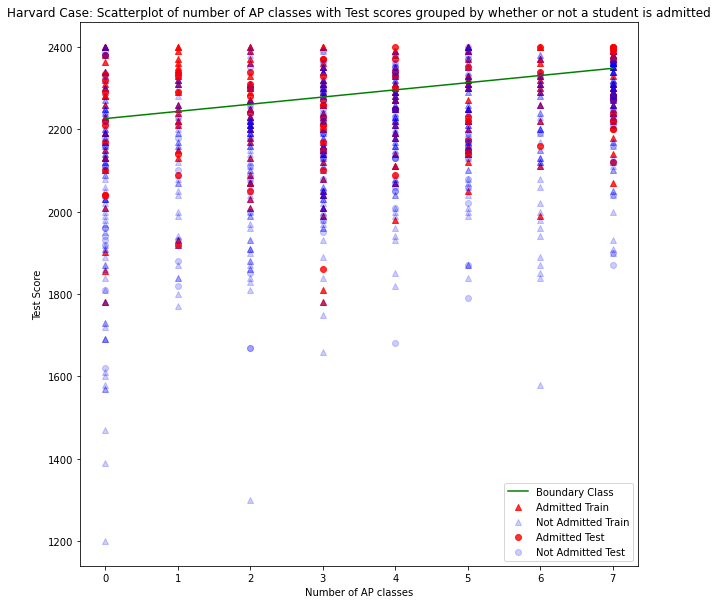

In [25]:
# your code here
plt.figure(figsize = (10,10))


#Train Data
plt.scatter(harvard_train[["ap"]][harvard_train['admitted'] == 1], harvard_train[["test"]][harvard_train['admitted'] == 1],c = "r", marker = "^", alpha = 0.8 ,label = 'Admitted Train')
plt.scatter(harvard_train[["ap"]][harvard_train['admitted'] != 1], harvard_train[["test"]][harvard_train['admitted'] != 1],c = "b", marker = "^", alpha = 0.2 ,label = 'Not Admitted Train')
# Test Data
plt.scatter(harvard_test[["ap"]][harvard_test['admitted'] == 1], harvard_test[["test"]][harvard_test['admitted'] == 1],c = "r", marker = "o", alpha = 0.8 ,label = 'Admitted Test')
plt.scatter(harvard_test[["ap"]][harvard_test['admitted'] != 1], harvard_test[["test"]][harvard_test['admitted'] != 1],c = "b", marker = "o", alpha = 0.2 ,label = 'Not Admitted Test')
#Boundary line
plt.plot([0,7],[2226,2348], 'g-', label = 'Boundary Class')

plt.legend()
plt.title("Harvard Case: Scatterplot of number of AP classes with Test scores grouped by whether or not a student is admitted")
plt.xlabel("Number of AP classes")
plt.ylabel("Test Score")


Text(0, 0.5, 'Test Score')

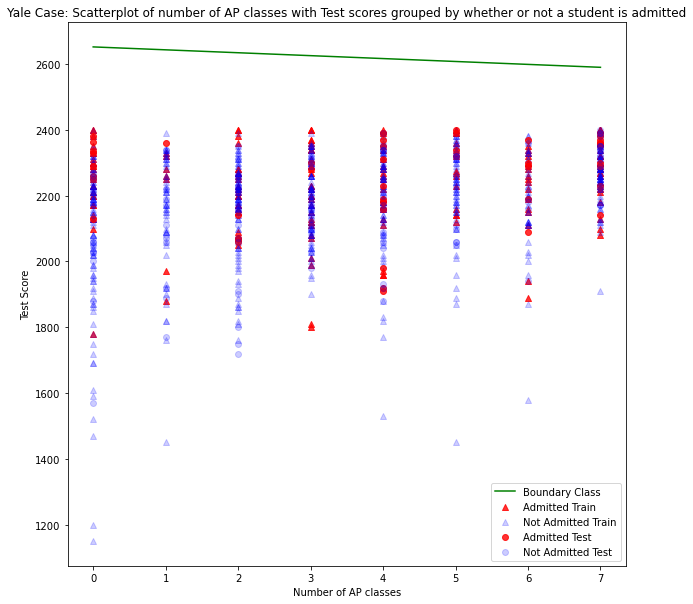

In [26]:
plt.figure(figsize = (10,10))


#Train Data
plt.scatter(yale_train[["ap"]][yale_train['admitted'] == 1],yale_train[["test"]][yale_train['admitted'] == 1],c = "r", marker = "^", alpha = 0.8 ,label = 'Admitted Train')
plt.scatter(yale_train[["ap"]][yale_train['admitted'] != 1], yale_train[["test"]][yale_train['admitted'] != 1],c = "b", marker = "^", alpha = 0.2 ,label = 'Not Admitted Train')
# Test Data
plt.scatter(yale_test[["ap"]][yale_test['admitted'] == 1], yale_test[["test"]][yale_test['admitted'] == 1],c = "r", marker = "o", alpha = 0.8 ,label = 'Admitted Test')
plt.scatter(yale_test[["ap"]][yale_test['admitted'] != 1], yale_test[["test"]][yale_test['admitted'] != 1],c = "b", marker = "o", alpha = 0.2 ,label = 'Not Admitted Test')
#Boundary line
plt.plot([0,7],[2652,2590], 'g-', label = 'Boundary Class')

plt.legend()
plt.title("Yale Case: Scatterplot of number of AP classes with Test scores grouped by whether or not a student is admitted")
plt.xlabel("Number of AP classes")
plt.ylabel("Test Score")

**INTERPRETATION:**

**your answer here:  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).**
It is difficult to distinguish between the scattering of the data between the Yale and Harvard case, but the clear different is where the boundary classification lie in each of the cases. In the Yale Case, the boundary line is above all of the data points. This coincides with our previous statements about how difficult it is to get into Yale because it shows that there is no realistic combination in our data set of test scores and amount of ap class to guarantee someone a 50% of getting into Yale. This matches what we found in question 2.2 about the test score needed to get a 50% chance of acceptance to either school, which was above the possible scoring. This makes sense with what we know about College admittance in general, and how difficult it is to get into an Ivy League shool. The Harvard case also matches our previous observances because the boundary class does intersect the data showing that there is a range or test scores that a person can have to match the amount of ap classes they take to have a 50% change of getting into Harvard. This does match that it is "easier" (in regards to this dataset) to get into Harvard. 

<div class='exercise-r'>

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.
    
</div>

In [27]:
# your code here
# interaction terms
harvard_female = college_train.harvard.values * college_train.female.values
harvard_minority = college_train.harvard.values * college_train.minority.values

admit_train = college_train["admitted"]
x_train = college_train[['harvard', 'test', 'female', 'minority']]
x_train.insert(4,'harvard_female', harvard_female)
x_train.insert(5, 'harvard_minority', harvard_minority)

logit3_6 = LogisticRegression(penalty = "none", max_iter = 500).fit(x_train, admit_train)


In [28]:
predictors = []

for i in x_train.columns:
    predictors.append(i)

In [29]:
for i in range(len(predictors)):
    print(f"Here is the {predictors[i]} coefficient: {logit3_6.coef_[0][i]:.3f}\n")
print(f"Here is the intercept {logit3_6.intercept_[0]:.3f}")

Here is the harvard coefficient: 0.388

Here is the test coefficient: 0.004

Here is the female coefficient: 0.020

Here is the minority coefficient: 1.435

Here is the harvard_female coefficient: 0.075

Here is the harvard_minority coefficient: -1.060

Here is the intercept -10.649


<div class='exercise-r'>

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

**INTERPRETATION** \
Female coefficient = 0.02126198 \
Minority coefficient = 1.43676206 \
harvard_female coefficient = 0.07298145 \
harvard_minority coefficient = -1.06288451 
intercept = -10.64

Given that the intercept is negative, if we fixed all the other predictors, we would have in general less chance of being admitted than being not admitted.

For the other cases:

* The female coefficient is positive and so is the minority coefficent. This means they give positive slopes and if X value is 1 (meaning they are a women and are minorities) it will increase the likelihood of someone getting in to Harvard or Yale very slightly. 
* The harvard_female interaction term is also positive saying that if someone is applying to Harvard and is a Female there will be a positive slope or an increase likelihood of getting admitted. Meaning, that female applicants applying to Harvard have higher changes of being admitted compared to male applicants applying to Harvard. 
* This is not true for the harvard_minority interaction term, which is negative. This means that if someone is applying to Harvard and they are a minority they have a decreased chance of being admitted. Meaning, that it is easier for people not belonging to a minority of being admitted to harvard, if they applied to Harvard.

<div class='exercise-r'>

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

</div>

**your answer here** \
Based on the data, it shows that Harvard does a better job than Yale at accepting women but not accepting people who are minorities. This can be seen by the interaction terms. It is wrong to take this as the interpretation because we are only looking at a subset of the data to make our model and are not looking all pieces of data. We are also confined to these predictors to describe whether or not someone gets into either University rather than look holistically potentially. We do not consider other factors that may have allowed for a person to get accepted that can alter how certain terms interact with each other.

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted [24 pts]</div>

[Return to contents](#contents)

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)

<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

</div>

**INTERPRETATION:**
Scaling is important because when comparing test scores, which has a range of 0 to 2400, and ap scores, which has a range of 0 to 7, it is difficult to determine what is important or the weight of these values on admissions because of their different scale. Scaling is important for k-NN classification because it looks at the nearest neighbors to take an average and we want all the data points to be of similar scales. 

**your answer here**

In [30]:
# your code here
#college.head()

#Changes to train data
standardized = StandardScaler().fit(college_train[["test", "ap", "avg_ap", "sat_subjects", "gpa"]])
xtrain_st = standardized.transform(college_train[["test", "ap", "avg_ap", "sat_subjects", "gpa"]])
xtrain_st = pd.DataFrame(xtrain_st)
xtrain_st = xtrain_st.rename(columns = {0: "test_scale", 1: "ap_scale", 2: "avg_ap_scale", 3:"sat_subjects_scale", 4: "gpa_scale" })
xtrain_st = xtrain_st.sort_index()


new_xtrain = college_train.copy()
new_xtrain = new_xtrain.drop(["test", "ap", "avg_ap", "sat_subjects", "gpa"], axis = 1)
new_xtrain = new_xtrain.reset_index()

x_train = pd.concat([new_xtrain,xtrain_st],join= "inner", axis = 1)
#x_train.head()

In [31]:
#Changes to test data
# fit only on train & transform both test & train 
xtest_st = standardized.transform(college_test[["test", "ap", "avg_ap", "sat_subjects", "gpa"]])
xtest_st = pd.DataFrame(xtest_st)
xtest_st = xtest_st.rename(columns = {0: "test_scale", 1: "ap_scale", 2: "avg_ap_scale", 3:"sat_subjects_scale", 4: "gpa_scale" })
xtest_st = xtest_st.sort_index()

new_xtest = college_test.copy()
new_xtest = new_xtest.drop(["test", "ap", "avg_ap", "sat_subjects", "gpa"], axis = 1)
new_xtest = new_xtest.reset_index()
x_test = pd.concat([new_xtest,xtest_st], join = "inner", axis = 1)
#x_test.head()

<div class='exercise-r'>

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.
    
</div>

In [32]:
np.random.seed(121) # Do not delete or modify this line of code

# your code here

# remember to use scale & change school to harvard
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]

ytrain = college_train["admitted"]
xtrain = x_train.copy()

#creating xtrain with 12 predictors
xtrain = xtrain[predictors]

mean_train, mean_val = [],[]
ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors = k)
    #knn_model.fit(xtrain,ytrain)
    cs = cross_validate(knn_model,xtrain,ytrain,scoring = "accuracy",cv = 10, return_train_score = True) 
    mean_train.append(cs["train_score"].mean())
    mean_val.append(cs["test_score"].mean())
    

In [33]:
best_k_val = ks[np.argmax(mean_val)]

best_k_train = ks[np.argmax(mean_train)]

#need to check cause theres multiple of the same value 
print(f"Best K value in ks from validation scores: {best_k_val}")
print(f"Best K value in ks from training scores: {best_k_train}")

# accuracy_train_knn = mean_train[np.argmax(mean_train)]*100
# accuracy_val_knn = mean_val[np.argmax(mean_val)]*100
# print(f"Train accuracy from best K Value at {best_k_train}: {accuracy_train_knn:.3f}%")
# print(f"Validation accuracy from best K Value at {best_k_val}: {accuracy_val_knn:.3f}%")

Best K value in ks from validation scores: 21
Best K value in ks from training scores: 1


In [34]:
#Associated accuracy
# Double check if accuracy is from fitting the model or if you can take the associated
xtest = x_test.copy()

#creating xtrain with 12 predictors

# Need to refit the model with best k value from above
xtest = xtest[predictors]
ytest = college_test["admitted"]
knn_model = KNeighborsClassifier(n_neighbors = best_k_val)
knn_model.fit(xtrain,ytrain)
y_pred_train = knn_model.predict(xtrain)
y_pred_test = knn_model.predict(xtest)

accuracy_test_fit = accuracy_score(ytest,y_pred_test)*100
accuracy_train_fit = accuracy_score(ytrain,y_pred_train)*100

print(f"Accuracy Train with K = {best_k_val}: {accuracy_train_fit:.3f}%")
print(f"Accuracy Test with K = {best_k_val}: {accuracy_test_fit:.3f}%")

Accuracy Train with K = 21: 74.398%
Accuracy Test with K = 21: 70.133%


In [35]:
accuracy_dict  = {}
accuracy_dict["Problem 4.2: knn accuracy"] = accuracy_test_fit


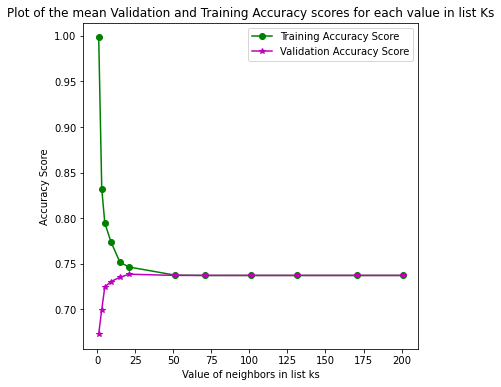

In [36]:
plt.figure(figsize = (6,6))
plt.plot(ks, mean_train, "go-", label = "Training Accuracy Score")
plt.plot(ks, mean_val, "m*-", label = "Validation Accuracy Score")
plt.xlabel("Value of neighbors in list ks")
plt.ylabel("Accuracy Score")
plt.title("Plot of the mean Validation and Training Accuracy scores for each value in list Ks")
plt.legend()

<div class='exercise-r'>

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [37]:
# your code here
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]

ytrain = college_train["admitted"]
x_train = xtrain.copy()

xtest = x_test.copy()
xtest = xtest[predictors]
ytest = college_test["admitted"]

logit_full = LogisticRegression(max_iter = 1000).fit(x_train,ytrain)
y_pred_train_3 = logit_full.predict(x_train)
y_pred_test_3 = logit_full.predict(xtest)


coef = logit_full.coef_[0]
intercept = logit_full.intercept_[0]

accuracy_train_3 = accuracy_score(ytrain, y_pred_train_3)*100
accuracy_test_3 = accuracy_score(ytest, y_pred_test_3)*100

print(f"Here is the accuracy score from the train data: {accuracy_train_3:.3f}%")
print(f"Here is the accuracy score from the test data: {accuracy_test_3:.3f}%")

Here is the accuracy score from the train data: 74.532%
Here is the accuracy score from the test data: 71.200%


In [38]:
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]

for i in range(len(predictors)):
    print(f"Here is the {predictors[i]} coefficient:{coef[i]:.3f} \n")
print(f"Here is the intercept {intercept:.3f}")

Here is the test_scale coefficient:0.771 

Here is the ap_scale coefficient:-0.134 

Here is the avg_ap_scale coefficient:0.090 

Here is the sat_subjects_scale coefficient:-0.093 

Here is the gpa_scale coefficient:0.102 

Here is the female coefficient:0.049 

Here is the minority coefficient:0.888 

Here is the international coefficient:0.413 

Here is the sports coefficient:1.119 

Here is the early_app coefficient:0.366 

Here is the alumni coefficient:0.627 

Here is the harvard coefficient:0.251 

Here is the intercept -1.682


In [39]:
accuracy_dict["Problem 4.3 logit_full"] = accuracy_test_3

<div class='exercise-r'>

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

</div>

In [40]:
# your code here
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]

ytrain = college_train["admitted"]
x_train = xtrain.copy()

xtest = x_test.copy()
xtest = xtest[predictors]
ytest = college_test["admitted"]

Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
cv = 10

# figure out the logit_lasso
#penalty is l1 for lasso
logit_lasso = LogisticRegressionCV(Cs= Cs, cv=cv, penalty='l1', solver='liblinear').fit(x_train, ytrain)
y_pred_train_4 = logit_lasso.predict(x_train)
y_pred_test_4 = logit_lasso.predict(xtest)

accuracy_train_4 = accuracy_score(ytrain, y_pred_train_4)*100
accuracy_test_4 = accuracy_score(ytest, y_pred_test_4)*100

intercept = logit_lasso.intercept_[0]
coef = logit_lasso.coef_[0]

print(f"Here is the accuracy score from the train data: {accuracy_train_4:.3f}%")
print(f"Here is the accuracy score from the test data: {accuracy_test_4:.3f}%")

Here is the accuracy score from the train data: 74.532%
Here is the accuracy score from the test data: 71.467%


In [41]:
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]

for i in range(len(predictors)):
    print(f" Here is the {predictors[i]} coefficient: {coef[i]:.3f} \n")
print(f"Here is the intercept: {intercept:.3f}")

 Here is the test_scale coefficient: 0.782 

 Here is the ap_scale coefficient: -0.139 

 Here is the avg_ap_scale coefficient: 0.095 

 Here is the sat_subjects_scale coefficient: -0.094 

 Here is the gpa_scale coefficient: 0.105 

 Here is the female coefficient: 0.049 

 Here is the minority coefficient: 0.912 

 Here is the international coefficient: 0.440 

 Here is the sports coefficient: 1.221 

 Here is the early_app coefficient: 0.370 

 Here is the alumni coefficient: 0.656 

 Here is the harvard coefficient: 0.255 

Here is the intercept: -1.701


In [42]:
accuracy_dict["Problem 4.4 Logit lasso"] = accuracy_test_4

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".
 
</div>

In [43]:
# your code here
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]
#coef[0][0]
len(predictors)

important_betas = []

for i in range(0, len(predictors)):
    if coef[i] != 0:
        important_betas.append(predictors[i])
    else:
        pass

print(f"Here are our list of important beta values: {important_betas} which is {len(important_betas)} out of\
 {len(predictors)}")

Here are our list of important beta values: ['test_scale', 'ap_scale', 'avg_ap_scale', 'sat_subjects_scale', 'gpa_scale', 'female', 'minority', 'international', 'sports', 'early_app', 'alumni', 'harvard'] which is 12 out of 12


<div class='exercise-r'>

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

</div>

In [44]:
# my function creates interaction terms & will update the values of x_train
# easy way to run through all possible combinations of predictors by starting at the beginning

def interaction(train,predictors,index):
    while index < len(predictors)-1:
        for i in range(1,len(predictors)):
            if index+i < len(predictors):
                int_train = train[[predictors[index]]].values*train[[predictors[index+i]]].values
                train.insert(0,f"{predictors[index]}_{predictors[index+i]}",int_train)
            else:
                pass
        index +=1
    return train


In [45]:
x_train = xtrain.copy()
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]
x_train_full = interaction(x_train,predictors, 0)
x_train_full.head()

,alumni_harvard,early_app_harvard,early_app_alumni,sports_harvard,sports_alumni,sports_early_app,international_harvard,international_alumni,international_early_app,international_sports,minority_harvard,minority_alumni,minority_early_app,minority_sports,minority_international,female_harvard,female_alumni,female_early_app,female_sports,female_international,female_minority,gpa_scale_harvard,gpa_scale_alumni,gpa_scale_early_app,gpa_scale_sports,...,ap_scale_sat_subjects_scale,ap_scale_avg_ap_scale,test_scale_harvard,test_scale_alumni,test_scale_early_app,test_scale_sports,test_scale_international,test_scale_minority,test_scale_female,test_scale_gpa_scale,test_scale_sat_subjects_scale,test_scale_avg_ap_scale,test_scale_ap_scale,test_scale,ap_scale,avg_ap_scale,sat_subjects_scale,gpa_scale,female,minority,international,sports,early_app,alumni,harvard
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.108,0.0,0.108,0.0,...,0.590,0.266,-0.620,-0.0,-0.620,-0.0,-0.0,-0.0,-0.620,-0.067,-0.546,-2.466e-01,-0.416,-0.620,0.670,0.398,0.881,0.108,1,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0.000,0.0,...,0.116,-0.037,0.000,0.0,0.000,0.0,0.0,0.0,0.026,0.012,0.003,-8.972e-04,0.029,0.026,1.099,-0.034,0.105,0.460,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.000,-0.0,-0.000,-0.0,...,-0.065,-0.281,-0.000,-0.0,-0.000,-0.0,-0.0,-0.0,-0.000,0.240,-0.028,-1.221e-01,0.165,-0.268,-0.616,0.456,0.105,-0.896,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000,0.0,0.610,0.0,...,0.116,-0.253,-0.000,-0.0,-0.385,-0.0,-0.0,-0.0,-0.385,-0.235,-0.041,8.858e-02,-0.423,-0.385,1.099,-0.230,0.105,0.610,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.610,0.0,0.000,0.0,...,1.110,0.503,1.261,0.0,0.000,0.0,0.0,0.0,1.261,0.770,2.089,9.468e-01,0.845,1.261,0.670,0.751,1.656,0.610,1,0,0,0,0,0,1


In [46]:
new_predictors = []
for col_name in x_train.columns: 
    new_predictors.append(col_name)
#len(new_predictors)

In [47]:
xtest = x_test.copy()
xtest = xtest[predictors]


In [48]:
# Only run once! It will give errors.
# or must run code before
predictors = ["test_scale", "ap_scale", "avg_ap_scale", "sat_subjects_scale","gpa_scale",\
"female", "minority", "international","sports", "early_app", "alumni", "harvard"]
x_test_full = interaction(xtest,predictors, 0)
#x_test_full.head()

In [49]:
# two way interactions
ytrain = college_train["admitted"]


#x_test = x_test.copy()
ytest = college_test["admitted"]

In [50]:
# your code here
cv = 10
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
logit_lasso_interact = LogisticRegressionCV(Cs= Cs, cv=cv, penalty='l1', solver='liblinear').fit(x_train_full, ytrain)
y_pred_train = logit_lasso_interact.predict(x_train_full)
y_pred_test = logit_lasso_interact.predict(x_test_full)

accuracy_train_int = accuracy_score(ytrain, y_pred_train)*100
accuracy_test_int = accuracy_score(ytest, y_pred_test)*100


intercept = logit_lasso_interact.intercept_
coef = logit_lasso_interact.coef_
#print(f" Here are the coefficients of the model: {coef}")
#print(f"Here is the intercept: {intercept}")
print(f"Here is the accuracy score from the train data: {accuracy_train_int:.3f}%")
print(f"Here is the accuracy score from the test data: {accuracy_test_int:.3f}%")


Here is the accuracy score from the train data: 76.471%
Here is the accuracy score from the test data: 70.400%


In [51]:
accuracy_dict["Problem 4.6 Logit lasso interact"] = accuracy_test_int

<div class='exercise-r'>

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)
    
</div>

In [52]:
# your code here
important_beta = 0

for i in range(0, len(new_predictors)):
    if coef[0][i] != 0:
        important_beta +=1
    else:
        pass

print(f"Here is the amount of important betas: {important_beta} out of the total amount of betas: {len(new_predictors)}")

Here is the amount of important betas: 60 out of the total amount of betas: 78


---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results [12 pts]</div>

[Return to contents](#contents)

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?


<a id="part5solutions"></a>

## Question 5: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [53]:
accuracy_dict

{'Problem 4.2: knn accuracy': 70.13333333333334,
 'Problem 4.3 logit_full': 71.2,
 'Problem 4.4 Logit lasso': 71.46666666666667,
 'Problem 4.6 Logit lasso interact': 70.39999999999999}

In [54]:
# your code here
accuracies = sorted(accuracy_dict.items())
key, val = zip(*accuracies)
best_acc = max(val)
index = val.index(best_acc)
best_model = key[index]

worst_acc = min(val)
index1 = val.index(worst_acc)
worst_model = key[index1]
print(f"Best accuracy is {best_acc:.3f} which corresponds to model: {best_model}")
print(f"Worst accuracy is {worst_acc:.3f} which corresponds to model: {worst_model}")

y_test = college_test['admitted']
y_predtest = np.zeros(len(y_test))
accuracy2 = accuracy_score(y_test, y_predtest)*100
print(f"Here is the accuracy of the naive model {accuracy2:.3f}% from Q1.1")

Best accuracy is 71.467 which corresponds to model: Problem 4.4 Logit lasso
Worst accuracy is 70.133 which corresponds to model: Problem 4.2: knn accuracy
Here is the accuracy of the naive model 70.133% from Q1.1


**INTERPRETATION:**

**your answer here**
This means the naive model has the same accuracy as our worst model, which is the knn model in question 4.2. This comparision tells us that our naive model is not a terrible indicator of whether or not someone will get into Harvard or Yale. This makes sense due to how hard it is to get into either school because if we just assume no one is going to get in that is a pretty safe or close guess to only ~4-5% getting in. 

<div class='exercise-r'>

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?
    
</div>

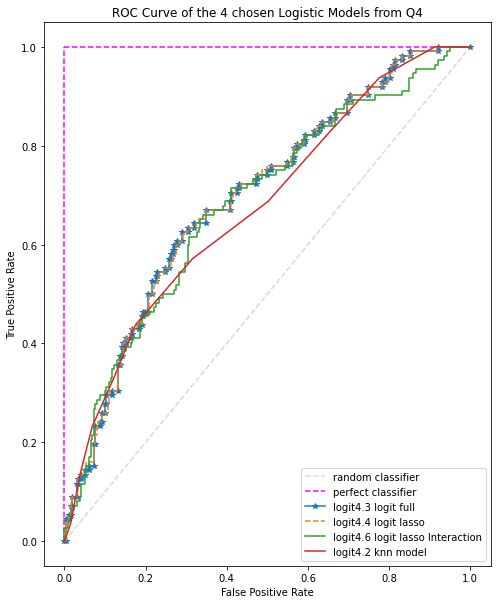

In [55]:
# your code here
# need the 4 models that do the best

# ROC Curves
#code from class
yhat_logit_3= logit_full.predict_proba(x_test[predictors])[:,1]
fpr3, tpr3, thresholds = roc_curve(ytest, yhat_logit_3)

yhat_logit_4= logit_lasso.predict_proba(x_test[predictors])[:,1]
fpr4, tpr4, thresholds = roc_curve(ytest,  yhat_logit_4)

yhat_logit_int= logit_lasso_interact.predict_proba(x_test_full[new_predictors])[:,1]
fpr6, tpr6, thresholds = roc_curve(ytest,  yhat_logit_int)

yhat_logit_knn= knn_model.predict_proba(x_test[predictors])[:,1]
fprknn, tprknn, thresholds = roc_curve(ytest,  yhat_logit_knn)

x=np.arange(0,100)/100
plt.figure(figsize=(8,10))
plt.plot(x,x,'--',color="gray",alpha=0.3, label = "random classifier")
plt.plot([0,1],[1,1],'--',color="magenta", label = "perfect classifier")
plt.plot([0,0],[0,1],'--',color="magenta")
plt.plot(fpr3,tpr3,'*-',label="logit4.3 logit full") # will need 4 of these
plt.plot(fpr4,tpr4,'--',label="logit4.4 logit lasso")
plt.plot(fpr6,tpr6,label="logit4.6 logit lasso Interaction")
plt.plot(fprknn,tprknn,label="logit4.2 knn model")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve of the 4 chosen Logistic Models from Q4")
plt.legend()
plt.show()

**INTERPRETATION:**

**your answer here How do these ROC curves compare? Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1? How do you know**
These ROC are hard to compare since quite a few of them overlap in more than one place. In 5.1, the worst model was knn and the best model was logit lasso. Here, the knn model does seem to be a bit lower in some place than the logit lasso but it doesn't seem to extremely distinguishable. Logit lasso is also not much higher or can be seen to be above the other models.

<div class='exercise-r'>

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

In [56]:
# your code here
auc_knn = roc_auc_score(ytest,yhat_logit_knn)
auc_logit_full = roc_auc_score(ytest,yhat_logit_3)
auc_logit_lasso = roc_auc_score(ytest,yhat_logit_4)
auc_logit_lasso_int = roc_auc_score(ytest,yhat_logit_int)

print(f"AUC score for Knn_model = {auc_knn:.4f}")
print(f"AUC score for logit_full model = {auc_logit_full:.4f}")
print(f"AUC score for logit_lasso model = {auc_logit_lasso:.4f}")
print(f"AUC score for logit_lasso interaction model = {auc_logit_lasso_int:.4f}")

AUC score for Knn_model = 0.6742
AUC score for logit_full model = 0.6971
AUC score for logit_lasso model = 0.6965
AUC score for logit_lasso interaction model = 0.6826


**INTERPRETATION:**

**your answer here: Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?**

The AUC rankings match the classification accuracy with the KNN model as the worst model. The logit full in AUC is the best model whereas in 5.1 with classification accuracy it was the logit lasso model. These could not match because the AUC score looks at area under the ROC curve where classification accuracy is the rate of correct identifiers. The ROC curve model is a measurement of showing how good the model is at correctly guessing the classifiers at different thresholds. The AUC value does show how well the model can predict between the classes. The accuracy score looks at how well we were able to predict the class from our model versus the actual true value. These will could have discrepancies in rankings because the AUC looks at many thresholds whereas accuracy looks at the actual difference in guesses.

<div class='exercise-r'>

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?
    
</div>

**your answer here**
I would use the logit lasso from Q4.4 because it had the highest classification accuracy. The higher the accuracy score means the better the model was at predicting whether or not someone would get in based off of our model. The biggest issue if this was a publicly available tool for college applicants is that it might not be the best representation as to why these students actually got into Harvard or Yale. There could be other predictors or reasons that are not presented in the data that could be why someone might have gotten in. A good example is the college essay and how that might impact acceptance. Another more modern/relevent example, is when parents buy a student's way into a school and that could not be represented in the data set. 

#### THE END

[Return to contents](#contents)